In [1]:
# Import Necessary Libraries and Functions

import torch
from PIL import Image
from monai_dataloader import augment_data, get_item, custom_collate, OCTDataset
from monai_model import CompleteNet, CNNBackbone
from monai_transforms import randSpatialCrop, randRotate, resize, composedTransform, identityTransform, ensureChannel
from monai_loss import contrastive_loss
from monai_train import predict, train_one_step, train_one_epoch, train
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# Niftys that have the MRIs I want to do the overfit test with

nifty_list = ['/Users/hairanliang/Downloads/sub-01_T1w.nii',
              '/Users/hairanliang/Downloads/sub-02_T1w.nii',
              '/Users/hairanliang/Downloads/sub-03_T1w.nii',
              '/Users/hairanliang/Downloads/sub-04_T1w.nii']

small_list = ['/Users/hairanliang/Downloads/sub-01_T1w.nii',
              '/Users/hairanliang/Downloads/sub-02_T1w.nii']

In [3]:
dataset = OCTDataset(nifty_list, True)

In [4]:
# Double-checking the length of the dataset is correct
len(dataset)

4

In [5]:
# Initializing Dataloader with batch_size and custom_collate function
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

In [6]:
# Checking to ensure shape is correct. This is correct because with 4 Niftys, we expect 8 augmented versions, along 
# with the channel dimension
batchTest = next(iter(dataloader))
print(batchTest.shape) 

torch.Size([8, 1, 50, 50, 50])


In [7]:
for batch_idx, batch in enumerate(dataloader):
    print(batch_idx, batch)

0 metatensor([[[[[8.5480e-01, 1.7945e+00, 2.7342e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [5.1284e-01, 1.4526e+00, 2.3923e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [1.7089e-01, 1.1106e+00, 2.0503e+00,  ..., 9.4968e-01,
            6.0773e-01, 2.6577e-01],
           ...,
           [1.5316e+00, 2.2155e+00, 2.8994e+00,  ..., 3.8491e+00,
            1.3318e+00, 1.0000e+00],
           [2.7945e+00, 2.4525e+00, 2.1106e+00,  ..., 2.8232e+00,
            2.3577e+00, 1.0000e+00],
           [1.7096e+00, 1.0257e+00, 3.4176e-01,  ..., 1.7973e+00,
            3.3835e+00, 1.0000e+00]],

          [[4.7096e+00, 4.2055e+00, 4.0000e+00,  ..., 8.2912e-01,
            4.8716e-01, 1.4521e-01],
           [4.0257e+00, 4.5474e+00, 4.0000e+00,  ..., 3.3182e-01,
            1.3577e+00, 2.3835e+00],
           [3.3418e+00, 4.8894e+00, 4.0000e+00,  ..., 2.9497e+00,
            2.6077e+00, 2.2658e+00],
           ...,
           [2.6578e-01, 6.0773e-0

In [8]:
# Initializing the ConvNet Model
backbone = CNNBackbone()
model = CompleteNet(backbone)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
train_one_step(batch, model, optimizer)

metatensor(1.9454, grad_fn=<AliasBackward0>)

In [10]:
train_one_epoch(dataloader, model, optimizer)

metatensor(1.9470, grad_fn=<AliasBackward0>)

In [11]:
# train(dataloader, model, optimizer, 50)

In [12]:
# loss_history = train(dataloader, model, optimizer, 50)

In [13]:
# plt.plot(loss_history)

Expectedly, the loss does not go down in the case when all the augmentations are random each time. The following is a demonstration that fixes the augmentation and uses that augmented version throughout training, just to make sure the model is able to learn in the 3-D case.

In [14]:
import monai.transforms as M

load_image_monai = M.LoadImage(reader='nibabelreader', image_only=True, reverse_indexing=False)

In [15]:
# Demonstration that lets us see how the values evolve over time during training

# get_item function is now coded out to see all the different parts separately
aug_list_1 = []
aug_list_2 = []
aug_list_3 = []
test_list_1 = ['/Users/hairanliang/Downloads/sub-01_T1w.nii',
              '/Users/hairanliang/Downloads/sub-02_T1w.nii',]
test_list_2 = ['/Users/hairanliang/Downloads/sub-03_T1w.nii',
              '/Users/hairanliang/Downloads/sub-04_T1w.nii']

full_list = nifty_list # All the nifty's together

for link in test_list_1:
    x = load_image_monai(link)
    x = ensureChannel(x) # IMPORTANT TO GET THE EXTRA CHANNEL DIMENSION 
    aug_x1 = augment_data(x, True)
    aug_x2 = augment_data(x, True)
    aug_list_1.extend([aug_x1, aug_x2]) 
aug_tensor_1 = torch.stack(aug_list_1, dim=0)


for link in test_list_2:
    x = load_image_monai(link)
    x = ensureChannel(x)
    aug_x1 = augment_data(x, True)
    aug_x2 = augment_data(x, True)
    aug_list_2.extend([aug_x1, aug_x2])
aug_tensor_2 = torch.stack(aug_list_2, dim=0)

for link in full_list:
    x = load_image_monai(link)
    x = ensureChannel(x)
    aug_x1 = augment_data(x, True)
    aug_x2 = augment_data(x, True)
    aug_list_3.extend([aug_x1, aug_x2])
aug_tensor_3 = torch.stack(aug_list_3, dim=0)

In [16]:
aug_tensor_1.shape

torch.Size([4, 1, 50, 50, 50])

In [17]:
new_aug_tensor = [aug_tensor_1, aug_tensor_2]

In [18]:
new_aug_tensor

[metatensor([[[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1550e+00,
             7.9686e+00, 5.8707e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.9979e+00,
             8.8116e+00, 2.4988e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.8409e+00,
             6.3817e+00, 1.2341e+00],
            ...,
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.9705e+01,
             3.4003e+01, 3.5268e+01],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             3.2028e+00, 1.7533e+01],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00]],
 
           [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.7325e+00,
             7.0313e+00, 4.4353e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.9969e+00,
             6.1884e+00, 2.7494e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.1591e+00,
             4.6908e+00, 3.1706e+00],
            ...,
            [0

In [19]:
aug_tensor_1.shape

torch.Size([4, 1, 50, 50, 50])

In [20]:
testBackbone = CNNBackbone()
testModel = CompleteNet(backbone)
learning_rate = 0.05
testOptimizer = torch.optim.SGD(testModel.parameters(), lr=learning_rate)

In [21]:
train_one_step(aug_tensor_1, testModel, testOptimizer) # Managed to get to 0.2404

metatensor(1.1041, grad_fn=<AliasBackward0>)

In [22]:
train_one_step(aug_tensor_3, testModel, testOptimizer)

metatensor(2.3975, grad_fn=<AliasBackward0>)

In [23]:
# This tests the train function. To mimic a dataloader, I simply used the list of new_aug_tensor
loss_history = train(new_aug_tensor, testModel, testOptimizer, 1000)

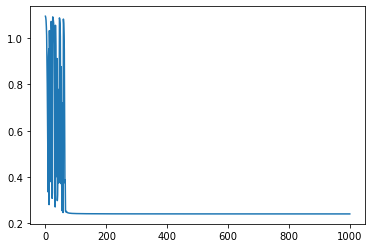

In [24]:
plt.plot(loss_history)

In [25]:
loss_history

[1.0955431461334229,
 1.090191125869751,
 1.0782227516174316,
 1.0520035028457642,
 1.0133600234985352,
 0.9106643199920654,
 0.8022288084030151,
 0.643864631652832,
 0.5089548826217651,
 0.33448725938796997,
 0.9206693172454834,
 0.9535526037216187,
 0.2798217535018921,
 1.0332773923873901,
 0.9264816045761108,
 0.6155058145523071,
 0.690902590751648,
 0.9079589247703552,
 0.3792385160923004,
 1.0732382535934448,
 1.02140212059021,
 0.635015606880188,
 0.3070703148841858,
 0.3323214650154114,
 1.0928109884262085,
 1.0871031284332275,
 1.0783977508544922,
 1.065555453300476,
 1.038460612297058,
 0.9753854274749756,
 0.7679276466369629,
 0.36974939703941345,
 0.2697060704231262,
 1.056452989578247,
 0.9669327139854431,
 0.6890183091163635,
 0.733669638633728,
 0.4010961651802063,
 0.9124186038970947,
 0.2971528470516205,
 0.32169628143310547,
 0.4172267019748688,
 0.778701663017273,
 0.721369206905365,
 0.373807430267334,
 0.5104895830154419,
 1.088370680809021,
 1.0817962884902954,
 1.